**Imports and setup**

In [1]:
import numpy as np
import tensorflow as tf
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

**Gradient Layer (Custom TensorFlow Layer)**

In [2]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        """
        Args:
            model: The neural network model that predicts psi and p
        """
        self.model = model
        super().__init__(**kwargs)

    def call(self, xy):
        """
        Computes gradients of the network outputs with respect to inputs.

        Args:
            xy: Input coordinates (x,y)

        Returns:
            Tuple containing (psi, pressure gradients, u gradients, v gradients)
        """
        x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
        # nested GradientTapes for 2nd derivatives
        with tf.GradientTape(persistent=True) as g2:
            g2.watch(x); g2.watch(y)
            with tf.GradientTape(persistent=True) as g1:
                g1.watch(x); g1.watch(y)
                with tf.GradientTape(persistent=True) as g0:
                    g0.watch(x); g0.watch(y)
                    psi_p = self.model(tf.concat([x, y], axis=-1))
                    psi = psi_p[..., 0, tf.newaxis]; p = psi_p[..., 1, tf.newaxis]
                u =  g0.batch_jacobian(psi, y)[...,0]
                v = -g0.batch_jacobian(psi, x)[...,0]
                p_x =  g0.batch_jacobian(p, x)[...,0]
                p_y =  g0.batch_jacobian(p, y)[...,0]
            u_x = g1.batch_jacobian(u, x)[...,0]; u_y = g1.batch_jacobian(u, y)[...,0]
            v_x = g1.batch_jacobian(v, x)[...,0]; v_y = g1.batch_jacobian(v, y)[...,0]
        u_xx = g2.batch_jacobian(u_x, x)[...,0]; u_yy = g2.batch_jacobian(u_y, y)[...,0]
        v_xx = g2.batch_jacobian(v_x, x)[...,0]; v_yy = g2.batch_jacobian(v_y, y)[...,0]
        p_grads = (p, p_x, p_y); u_grads = (u, u_x, u_y, u_xx, u_yy)
        v_grads = (v, v_x, v_y, v_xx, v_yy)
        return psi, p_grads, u_grads, v_grads

**Network**

In [3]:
class Network:
    def __init__(self):
        """Initializes with available activation functions"""
        self.activations = {
            'tanh' : 'tanh',
            'swish': self.swish,
            'mish' : self.mish,
        }

    def swish(self, x):
        """Swish activation function: x * sigmoid(x)"""
        return x * tf.math.sigmoid(x)

    def mish(self, x):
        """Mish activation function: x * tanh(softplus(x))"""
        return x * tf.math.tanh(tf.math.softplus(x))

    def build(self, num_inputs=2, layers=[32,32,32,32,32], activation='tanh', num_outputs=2):
        """
        Builds the neural network model.

        Args:
            num_inputs: Number of input features (x,y coordinates)
            layers: List of hidden layer sizes
            activation: Activation function to use
            num_outputs: Number of outputs (psi and pressure)

        Returns:
            A compiled Keras model
        """
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        x = inputs
        for units in layers:
            x = tf.keras.layers.Dense(units, activation=self.activations[activation],
                                      kernel_initializer='he_normal')(x)
        outputs = tf.keras.layers.Dense(num_outputs, kernel_initializer='he_normal')(x)
        return tf.keras.models.Model(inputs, outputs)

**L-BFGS-B Optimizer Wrapper**

In [4]:
class L_BFGS_B:
    def __init__(self, model, x_train, y_train, factr=10, pgtol=1e-10, m=50, maxls=50, maxiter=20000):
        """
        Args:
            model: The model to optimize
            x_train: Training inputs
            y_train: Training targets
            factr: Convergence threshold
            pgtol: Gradient tolerance
            m: Number of corrections used in L-BFGS
            maxls: Maximum line search steps
            maxiter: Maximum iterations
        """
        self.model = model
        self.x_train = [tf.constant(x, dtype=tf.float32) for x in x_train]
        self.y_train = [tf.constant(y, dtype=tf.float32) for y in y_train]
        self.factr, self.pgtol, self.m, self.maxls, self.maxiter = factr, pgtol, m, maxls, maxiter
        self.metrics = ['loss']
        self.progbar = tf.keras.callbacks.ProgbarLogger(stateful_metrics=self.metrics) if hasattr(tf.keras.callbacks.ProgbarLogger, 'stateful_metrics') else tf.keras.callbacks.ProgbarLogger()
        self.progbar.set_params({'verbose':1,'epochs':1,'steps':self.maxiter,'metrics':self.metrics})
        self.loss_history = []

    def set_weights(self, flat_w):
        """Sets model weights from flattened array"""
        shapes = [w.shape for w in self.model.get_weights()]
        split = np.cumsum([np.prod(s) for s in [0]+shapes])
        wts = [ flat_w[split[i]:split[i+1]].reshape(shapes[i])
                for i in range(len(shapes)) ]
        self.model.set_weights(wts)

    @tf.function
    def tf_evaluate(self, x, y):
        """Computes loss and gradients for given inputs and targets"""
        with tf.GradientTape() as g:
            y_pred = self.model(x)
            losses = [tf.reduce_mean(tf.keras.losses.logcosh(pred, target))
                      for pred, target in zip(y_pred, y)]
            loss = tf.reduce_sum(losses)
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, w):
        """Evaluates loss and gradients for scipy optimizer"""
        self.set_weights(w)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        return loss.numpy().astype('float64'), np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')

    def callback(self, w):
        """Callback for tracking progress"""
        self.progbar.on_batch_begin(0)
        loss,_ = self.evaluate(w)
        self.progbar.on_batch_end(0, logs={'loss':loss})
        self.loss_history.append(loss)
        if len(self.loss_history) % 500 == 0:
            print(f"Iteration {len(self.loss_history)}: Loss = {loss}")

    def fit(self):
        """Runs the optimization"""
        init_w = np.concatenate([w.flatten() for w in self.model.get_weights()])
        print(f'Optimizer: L-BFGS-B (maxiter={self.maxiter})')
        self.progbar.on_train_begin(); self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=init_w,
            factr=self.factr, pgtol=self.pgtol, m=self.m,
            maxls=self.maxls, maxiter=self.maxiter, callback=self.callback)
        self.progbar.on_epoch_end(1); self.progbar.on_train_end()

**PINN Model Builder**

In [5]:
class PINN:
    def __init__(self, network, rho=1, nu=0.01):
        """
        Args:
            network: The neural network model
            rho: Fluid density
            nu: Kinematic viscosity
        """
        self.network, self.rho, self.nu = network, rho, nu
        self.grads = GradientLayer(self.network)

    def build(self):
        """Builds the PINN model with physics-based loss terms"""
        xy_eqn = tf.keras.layers.Input(shape=(2,))
        xy_bnd = tf.keras.layers.Input(shape=(2,))

        # Equation residuals
        _, p_grads, u_grads, v_grads = self.grads(xy_eqn)
        u, u_x, u_y, u_xx, u_yy = u_grads
        v, v_x, v_y, v_xx, v_yy = v_grads
        p_x, p_y = p_grads[1], p_grads[2]

        uv_eqn = tf.keras.layers.Lambda(lambda inputs:
            tf.concat([
                inputs[0]*inputs[1] + inputs[2]*inputs[3] + inputs[4]/self.rho - self.nu*(inputs[5]+inputs[6]),  # x-momentum
                inputs[0]*inputs[7] + inputs[2]*inputs[8] + inputs[9]/self.rho - self.nu*(inputs[10]+inputs[11])  # y-momentum
            ], axis=-1))([u, u_x, v, u_y, p_x, u_xx, u_yy, v_x, v_y, p_y, v_xx, v_yy])

        # Boundary conditions
        psi_bnd, _, u_grads_b, v_grads_b = self.grads(xy_bnd)
        psi_bc = tf.keras.layers.Lambda(lambda x: x[:, 0:1])(psi_bnd)  # ψ=0 on boundaries
        uv_bc = tf.keras.layers.Lambda(lambda inputs: tf.concat([inputs[0], inputs[1]], axis=-1))(
            [u_grads_b[0], v_grads_b[0]]  # [u, v] BCs
        )

        return tf.keras.models.Model(inputs=[xy_eqn, xy_bnd], outputs=[uv_eqn, psi_bc, uv_bc])

**Utility Functions**

In [6]:
def uv(network, xy):
    """
    Computes velocity components (u,v) from stream function psi.

    Args:
        network: Trained model
        xy: Input coordinates

    Returns:
        Tuple of (u, v) velocity components
    """
    xy_t = tf.constant(xy)
    with tf.GradientTape() as g:
        g.watch(xy_t)
        psi_p = network(xy_t)
    J = g.batch_jacobian(psi_p, xy_t)
    return J[...,0,1].numpy(), -J[...,0,0].numpy()

def contour(grid, x, y, z, title, levels=50):
    """
    Creates a contour plot.

    Args:
        grid: GridSpec position
        x: x coordinates
        y: y coordinates
        z: Values to contour
        title: Plot title
        levels: Number of contour levels
    """
    vmin, vmax = z.min(), z.max()
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels,
                 norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)

**Training and Visualization**

In [8]:
# Cell 7: Training Execution
"""
Main execution block for training the PINN.
"""
if __name__=='__main__':
    # Configuration
    N_train, N_test = 10000, 100
    u0, rho, nu = 1, 1, 0.01

    # Build models
    net = Network().build()
    net.summary()
    pinn_model = PINN(net, rho, nu).build()

    # Generate training data
    xy_eqn = np.random.rand(N_train,2)

    def generate_bc_points(n_total, u0=1):
        n = n_total // 4
        top = np.hstack([np.random.rand(n, 1), np.ones((n, 1))])
        bottom = np.hstack([np.random.rand(n, 1), np.zeros((n, 1))])
        left = np.hstack([np.zeros((n, 1)), np.random.rand(n, 1)])
        right = np.hstack([np.ones((n, 1)), np.random.rand(n, 1)])
        return np.vstack([top, bottom, left, right])

    xy_bnd = generate_bc_points(N_train)

    # Boundary conditions
    uv_bnd = np.zeros((N_train, 2))
    is_top_wall = (xy_bnd[:, 1] == 1)
    uv_bnd[is_top_wall, 0] = u0

    # Loss targets
    zeros = np.zeros((N_train, 2))
    psi_bc_target = np.zeros((N_train, 1))
    y_train = [zeros, psi_bc_target, uv_bnd]

    # Train
    opt = L_BFGS_B(pinn_model, [xy_eqn, xy_bnd], y_train)
    opt.fit()

    # Generate predictions
    x_lin = np.linspace(0,1,N_test)
    y_lin = np.linspace(0,1,N_test)
    X,Y = np.meshgrid(x_lin,y_lin)
    XY = np.stack([X.ravel(),Y.ravel()],1)

    psi_p = net.predict(XY, batch_size=len(XY))
    psi, p = psi_p[:,0].reshape(X.shape), psi_p[:,1].reshape(X.shape)
    u, v = uv(net, XY)
    u, v = u.reshape(X.shape), v.reshape(X.shape)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386 (17.13 KB)

 Trainable params: 4,386 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Optimizer: L-BFGS-B (maxiter=20000)
Iteration 500: Loss = 0.0029963538981974125
Iteration 1000: Loss = 0.0013806798961013556
Iteration 1500: Loss = 0.000899250153452158
Iteration 2000: Loss = 0.0007079858332872391
Iteration 2500: Loss = 0.0005944691365584731
Iteration 3000: Loss = 0.000522351823747158
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4782s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


**Visulization 1**

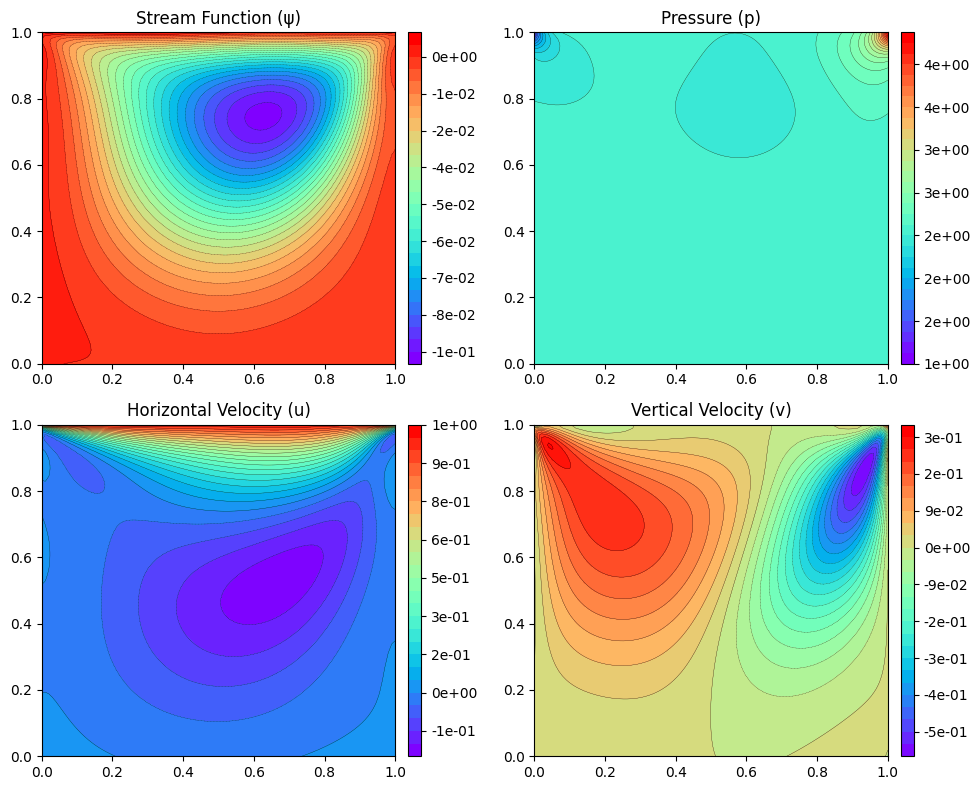

In [9]:
# Cell 8: Visualization
"""
Visualization of the PINN results.
This cell should be run after Cell 7.
"""
if 'X' in globals() and 'Y' in globals():  # Check if variables exist
    fig = plt.figure(figsize=(10,8))
    gs = GridSpec(2,2)

    # Create plots with improved formatting
    contour(gs[0,0], X, Y, psi, 'Stream Function (ψ)', levels=30)
    contour(gs[0,1], X, Y, p, 'Pressure (p)', levels=30)
    contour(gs[1,0], X, Y, u, 'Horizontal Velocity (u)', levels=30)
    contour(gs[1,1], X, Y, v, 'Vertical Velocity (v)', levels=30)

    plt.tight_layout()
    plt.show()
else:
    print("Error: Run Cell 7 first to generate the required variables")

**Data from Ghia's Reference**

In [10]:
y_u = np.array([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000])
u_Re100 = np.array([1.00000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.21090, -0.15662, -0.10150, -0.06434, -0.04775, -0.04192, -0.03717, 0.00000])


**Visualization**

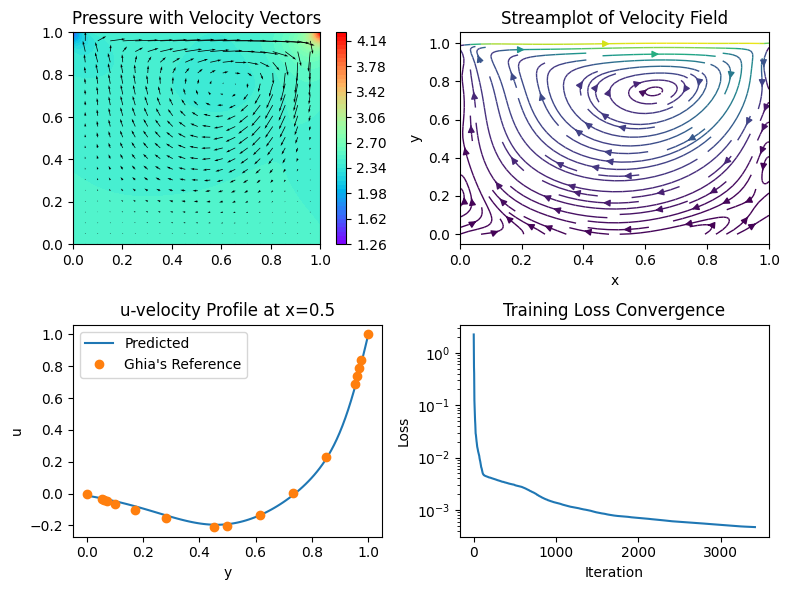

In [11]:
# Create 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(8,6))

# Top-left: Pressure with Velocity Vectors
contour = axs[0, 0].contourf(X, Y, p, levels=50, cmap='rainbow')
plt.colorbar(contour, ax=axs[0, 0])
stride = 5
axs[0, 0].quiver(X[::stride, ::stride], Y[::stride, ::stride],
                 u[::stride, ::stride], v[::stride, ::stride], color='k')
axs[0, 0].set_title('Pressure with Velocity Vectors')

# Top-right: Streamplot of Velocity Field
axs[0, 1].streamplot(X, Y, u, v, color=np.sqrt(u**2 + v**2), cmap='viridis', linewidth=1)
axs[0, 1].set_title('Streamplot of Velocity Field')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')

# Bottom-left: u-velocity Profile at x=0.5
mid_x = np.argmin(np.abs(x_lin - 0.5))
axs[1, 0].plot(y_lin, u[:, mid_x], label='Predicted')
axs[1, 0].plot(y_u, u_Re100, 'o', label='Ghia\'s Reference')
axs[1, 0].set_title('u-velocity Profile at x=0.5')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('u')
axs[1, 0].legend()

# Bottom-right: Training Loss Convergence
axs[1, 1].semilogy(opt.loss_history)
axs[1, 1].set_title('Training Loss Convergence')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
